In [41]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from joblib import dump, load

import tqdm
from tqdm import tqdm

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [3]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
ids = mailout_test['LNR']
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [4]:
type_lookup = pd.read_csv('./data/type_lookup.csv')
type_lookup.head()

,attr,datatype
0,KBA13_CCM_2500,numerical
1,KBA13_HALTER_40,numerical
2,KBA05_SEG9,numerical
3,D19_VERSAND_ONLINE_QUOTE_13,numerical
4,KBA13_TOYOTA,numerical


In [5]:
model_feat =  pd.read_csv('./data/model_feat.csv')
model_feat.head()

,model_feat
0,AGER_TYP
1,ALTER_HH
2,ANZ_HAUSHALTE_AKTIV
3,ANZ_HH_TITEL
4,ANZ_PERSONEN


In [6]:
model_feat = list(model_feat['model_feat'])
train_feat = list(mailout_train.columns)
test_feat = list(mailout_test.columns)

In [7]:
#Find model features not in customer features
model_feat_notin_train = [feat for feat in model_feat if feat not in train_feat]
model_feat_notin_test = [feat for feat in model_feat if feat not in test_feat]

len(model_feat_notin_train),len(model_feat_notin_test)

(0, 0)

# TRAIN

In [8]:
#Response DF LNR,REPONSE,CLUSTER_LABEL

train_response_df = pd.DataFrame()
train_response_df['LNR'] = mailout_train['LNR']
train_response_df['RESPONSE'] = mailout_train['RESPONSE']
train_response_df.head()

,LNR,RESPONSE
0,1763,0
1,1771,0
2,1776,0
3,1460,0
4,1783,0


In [9]:
extra_columns = ['RESPONSE']
mailout_train_extra = mailout_train[extra_columns  + ['LNR']]
mailout_train = mailout_train.drop(extra_columns, axis=1)
mailout_train = mailout_train[model_feat]
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,8.0,15.0,0.0,1.0,0.0,5.0,5D,5,2.0,...,3,3,0.0,2,6.0,9.0,3.0,3,2,4
1,1,13.0,1.0,0.0,2.0,0.0,5.0,5B,5,2.0,...,4,2,0.0,1,4.0,9.0,7.0,1,2,3
2,1,9.0,0.0,NaN,0.0,0.0,1.0,2D,2,4.0,...,7,3,0.0,1,NaN,9.0,2.0,3,1,4
3,2,6.0,4.0,0.0,2.0,0.0,2.0,2D,2,2.0,...,2,1,0.0,2,6.0,9.0,1.0,3,2,4
4,2,9.0,53.0,0.0,1.0,0.0,4.0,7B,7,6.0,...,7,1,0.0,1,6.0,9.0,3.0,3,1,3


In [10]:
mailout_train.shape

(42962, 272)

In [11]:
#FILLNA CATEGORICAL FEATS
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_col = ['OST_WEST_KZ','CAMEO_DEU_2015']

for cat in cat_col:
    mailout_train[cat] = mailout_train[cat].fillna('Unknown') 
    mailout_train[cat] = le.fit_transform(mailout_train[cat])

In [12]:
clean_feat = pd.read_csv('./data/clean_features.csv')
clean_feat.head()

,Attribute,Value,Is_Numerical
0,AGER_TYP,99,1
1,AGER_TYP,0,1
2,AGER_TYP,1,1
3,AGER_TYP,2,1
4,AGER_TYP,3,1


In [13]:
#FILLNA NUMERICAL FEATS
num_cols = [feat for feat in model_feat if feat not in cat_col]

for cat in tqdm(num_cols):
    #print(cat)
    temp_list = []
    temp_df = clean_feat[clean_feat['Attribute'] == cat]
    
    for val in mailout_train[cat]:
        try:
            val = int(val)
            if val in temp_df['Value']:
                temp_list.append(val)
            else:
                temp_list.append(99)
        except:
            temp_list.append(99)
    mailout_train[cat] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:32<00:00,  8.66it/s]


In [14]:
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,99,99,99,99,99,99,21,99,99,...,99,99,99,99,99,99,99,99,99,99
1,1,13,99,99,99,99,99,19,99,99,...,99,99,99,99,99,99,99,99,99,99
2,1,99,99,99,99,99,99,8,99,99,...,99,99,99,99,99,99,99,99,99,99
3,2,99,99,99,99,99,99,8,99,99,...,99,99,99,99,99,99,99,99,99,99
4,2,99,99,99,99,99,99,31,99,99,...,99,99,99,99,99,99,99,99,99,99


In [15]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

mailout_train = scaler.fit_transform(mailout_train)
mailout_train = pd.DataFrame(mailout_train, columns=model_feat)

In [16]:
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,-0.291845,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462
1,-0.861189,-1.306155,0.036768,0.0,0.0,0.0,0.0,-0.433462,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462
2,-0.861189,0.799598,0.036768,0.0,0.0,0.0,0.0,-1.212355,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462
3,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,-1.212355,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462
4,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,0.416239,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462


In [17]:
from joblib import dump, load

pca = load('dump/pca.joblib')

kmeans = load('dump/kmeans_model.joblib')

In [18]:
mailout_train_pca = pca.transform(mailout_train)
mailout_train_labels = kmeans.predict(mailout_train_pca)


In [19]:
train_label_df = pd.DataFrame(list(mailout_train_labels), columns=['CLUSTER_LABEL'])
train_label_df.head()

,CLUSTER_LABEL
0,3
1,2
2,3
3,3
4,3


In [20]:
train_response_df['CLUSTER_LABEL'] = train_label_df['CLUSTER_LABEL']
train_response_df.head()

,LNR,RESPONSE,CLUSTER_LABEL
0,1763,0,3
1,1771,0,2
2,1776,0,3
3,1460,0,3
4,1783,0,3


In [21]:
import seaborn as sns
sns.set(style="darkgrid")

ax = sns.countplot(x="RESPONSE", hue="CLUSTER_LABEL", data=train_response_df)

In [22]:
from imblearn.over_sampling import SMOTE

In [23]:
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,-0.291845,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462
1,-0.861189,-1.306155,0.036768,0.0,0.0,0.0,0.0,-0.433462,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462
2,-0.861189,0.799598,0.036768,0.0,0.0,0.0,0.0,-1.212355,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462
3,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,-1.212355,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462
4,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,0.416239,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462


In [24]:
X = mailout_train
y = train_response_df[['RESPONSE']]

In [25]:
resampler = SMOTE(random_state=777)
X_res, y_res = resampler.fit_sample(X, y.values)
print(X_res.shape, y_res.shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(84860, 272) (84860,)


In [26]:
x_df = pd.DataFrame(X_res, columns=X.columns)
y_df = pd.DataFrame(y_res, columns=y.columns)

In [27]:
smote_train_df = pd.merge(x_df , y_df, left_index=True, right_index=True)

In [28]:
smote_train_df.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,-0.291845,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462,0
1,-0.861189,-1.306155,0.036768,0.0,0.0,0.0,0.0,-0.433462,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462,0
2,-0.861189,0.799598,0.036768,0.0,0.0,0.0,0.0,-1.212355,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462,0
3,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,-1.212355,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462,0
4,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,0.416239,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462,0


In [29]:
smote_train_response_df = pd.DataFrame()
smote_train_response_df['RESPONSE'] = smote_train_df['RESPONSE']

In [30]:
smote_mailout_train_pca = pca.transform(x_df)
smote_mailout_train_labels = kmeans.predict(smote_mailout_train_pca)
smote_train_label_df = pd.DataFrame(list(smote_mailout_train_labels), columns=['CLUSTER_LABEL'])
smote_train_response_df['CLUSTER_LABEL'] = smote_train_label_df['CLUSTER_LABEL']
smote_train_response_df.head()

,RESPONSE,CLUSTER_LABEL
0,0,3
1,0,2
2,0,3
3,0,3
4,0,3


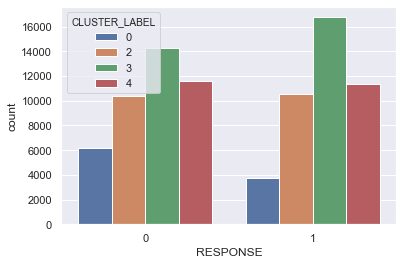

In [31]:
ax = sns.countplot(x="RESPONSE", hue="CLUSTER_LABEL", data=smote_train_response_df)

TRAIN THE MODEL

In [32]:
smote_train_df.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,-0.291845,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462,0
1,-0.861189,-1.306155,0.036768,0.0,0.0,0.0,0.0,-0.433462,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462,0
2,-0.861189,0.799598,0.036768,0.0,0.0,0.0,0.0,-1.212355,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462,0
3,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,-1.212355,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462,0
4,-0.840364,0.799598,0.036768,0.0,0.0,0.0,0.0,0.416239,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043462,0


In [35]:
#split data
X = smote_train_df[model_feat]
y = smote_train_df['RESPONSE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

In [4]:
# clf = XGBClassifier(colsample_bytree=0.75,
#                     eta=0.25,
#                     gamma=0.5,
#                     max_depth=8,
#                     min_child_weight=1,
#                     n_estimators=673,
#                     subsample=0.8,
#                     random_state = 777, 
#                     tree_method='gpu_hist')

In [ ]:
# xgboost = clf.fit(X_train, y_train)
# y_pred = xgboost.predict(X_val)

# print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

In [99]:
clf = RandomForestClassifier(n_estimators=500, max_depth=1000,random_state=10)
rfc = clf.fit(X_train, y_train) 

In [100]:
y_pred = rfc.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.8416214942257837


In [47]:
#export model
# dump(xgboost, './dump/xgboost.joblib')
dump(rfc, './dump/rfc.joblib')

['./dump/rfc.joblib']

In [2]:
#import model
# xgboost = load('dump/xgboost.joblib')
rfc = load('dump/rfc.joblib')

# Test Model

In [48]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [49]:
model_feat = pd.read_csv('./data/model_feat.csv')
model_feat.head()

,model_feat
0,AGER_TYP
1,ALTER_HH
2,ANZ_HAUSHALTE_AKTIV
3,ANZ_HH_TITEL
4,ANZ_PERSONEN


In [50]:
model_feat = list(model_feat['model_feat'])
len(model_feat)

272

In [51]:
mailout_test = mailout_test[model_feat]
mailout_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,7.0,2.0,0.0,2.0,0.0,6.0,2B,2,5.0,...,7,3,0.0,1,6.0,9.0,3.0,3,1,4
1,-1,0.0,20.0,0.0,1.0,0.0,7.0,5A,5,1.0,...,6,2,0.0,1,6.0,9.0,5.0,3,1,4
2,2,16.0,2.0,0.0,4.0,0.0,1.0,7A,7,2.0,...,3,3,0.0,1,2.0,9.0,4.0,3,2,4
3,-1,0.0,1.0,0.0,0.0,0.0,1.0,2B,2,4.0,...,2,3,0.0,2,NaN,9.0,2.0,3,2,4
4,1,21.0,1.0,0.0,4.0,0.0,6.0,5A,5,6.0,...,3,3,0.0,1,3.0,9.0,7.0,4,2,4


In [52]:
X_test = mailout_test

In [53]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cat_col = ['OST_WEST_KZ','CAMEO_DEU_2015']

for cat in cat_col:
    X_test[cat] = X_test[cat].fillna('Unknown') 
    X_test[cat] = le.fit_transform(X_test[cat])

In [54]:
#FILLNA NUMERICAL FEATS
num_cols = [feat for feat in model_feat if feat not in cat_col]

for cat in tqdm(num_cols):
    #print(cat)
    temp_list = []
    temp_df = clean_feat[clean_feat['Attribute'] == cat]
    
    for val in X_test[cat]:
        try:
            val = int(val)
            if val in temp_df['Value']:
                temp_list.append(val)
            else:
                temp_list.append(99)
        except:
            temp_list.append(99)
    X_test[cat] = temp_list
    X_test[cat] = le.fit_transform(X_test[cat])

100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:33<00:00,  8.64it/s]


In [55]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,11,1,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4,11,1,0,0,0,0,18,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,5,1,0,0,0,0,30,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,11,1,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,10,1,0,0,0,0,18,0,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=model_feat)

In [57]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.50,1.000000,1.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.00,1.000000,1.0,0.0,0.0,0.0,0.0,0.400000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.454545,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.00,1.000000,1.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.25,0.909091,1.0,0.0,0.0,0.0,0.0,0.400000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X_test.to_csv('X_test.csv', index=False)

In [3]:
X_test = pd.read_csv('./data/X_test.csv')
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.50,1.000000,1.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.00,1.000000,1.0,0.0,0.0,0.0,0.0,0.400000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.454545,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.00,1.000000,1.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.25,0.909091,1.0,0.0,0.0,0.0,0.0,0.400000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [90]:
y_pred = rfc.predict_proba(X_test)

In [91]:
y_pred_target = rfc.predict(X_test)

In [92]:
y_pred_target

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [93]:
y_pred

array([[0.95      , 0.05      ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.27532221, 0.72467779]])

In [94]:
submission_df = pd.DataFrame()
submission_df['LNR'] = ids
submission_df['PROB_0'] = [ probs[0] for probs in y_pred ]
submission_df['PROB_1'] = [ probs[1] for probs in y_pred ]
submission_df['PREDICTION'] = y_pred_target

In [95]:
submission_df.head()

,LNR,PROB_0,PROB_1,PREDICTION
0,1754,0.950000,0.050000,0
1,1770,0.000000,1.000000,1
2,1465,0.000000,1.000000,1
3,1470,0.573966,0.426034,0
4,1478,0.000000,1.000000,1


In [96]:
submission_df.shape

(42833, 4)

In [97]:
submit = pd.DataFrame()
submit['LNR'] = submission_df['LNR']
submit['RESPONSE'] = submission_df['PROB_1']

In [98]:
submit.to_csv('./data/submit.csv', index=False)